<a href="https://colab.research.google.com/github/Lubricy/notebooks/blob/master/btc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%tensorflow_version 2.x
!pip install --upgrade tensorflow-probability
!pip install mpl_axes_aligner
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from mpl_axes_aligner import align

print(tf.version.VERSION)
print(tfp.python.version.__version__)
print(tf.test.gpu_device_name())

TensorFlow 2.x selected.
     |████████████████████████████████| 2.5MB 6.4MB/s 
ERROR: tensor2tensor 1.14.1 has requirement tensorflow-probability==0.7.0, but you'll have tensorflow-probability 0.8.0 which is incompatible.
ERROR: gym 0.15.4 has requirement cloudpickle~=1.2.0, but you'll have cloudpickle 1.1.1 which is incompatible.
  Found existing installation: cloudpickle 1.2.2
    Uninstalling cloudpickle-1.2.2:
      Successfully uninstalled cloudpickle-1.2.2
  Found existing installation: tensorflow-probability 0.7.0
    Uninstalling tensorflow-probability-0.7.0:
      Successfully uninstalled tensorflow-probability-0.7.0


2.1.0-rc1
0.8.0
/device:GPU:0


In [3]:
import pandas as pd
import urllib

COIN_NAMES=['BTC', 'ETH', 'LTC']

data={}
for coin in COIN_NAMES:
  with urllib.request.urlopen(f"http://www.cryptodatadownload.com/cdd/Coinbase_{coin}USD_1h.csv") as f:
    print(next(f))
    data[coin] = pd.read_csv(f)

b'Timestamps are UTC timezone,https://www.CryptoDataDownload.com\r\n'
b'Timestamps are UTC timezone,https://www.CryptoDataDownload.com\r\n'
b'Timestamps are UTC timezone,https://www.CryptoDataDownload.com\r\n'


In [0]:
# data cleaning

for _, df in data.items():
  df['Date']= pd.to_datetime(df['Date'], format='%Y-%m-%d %I-%p') 

In [5]:
#@title COIN
COIN = 'ETH' #@param ['BTC', 'ETH', 'LTC']
display(data[COIN].columns)
display(data[COIN])
display(data[COIN].dtypes)

Index(['Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume ETH',
       'Volume USD'],
      dtype='object')

,Date,Symbol,Open,High,Low,Close,Volume ETH,Volume USD
0,2020-01-03 05:00:00,ETHUSD,129.15,129.67,129.15,129.67,0.00,0.00
1,2020-01-03 04:00:00,ETHUSD,126.52,129.83,126.51,129.15,6913.15,887534.69
2,2020-01-03 03:00:00,ETHUSD,126.61,126.69,126.23,126.52,1669.17,210999.73
3,2020-01-03 02:00:00,ETHUSD,125.63,126.65,125.53,126.61,1713.95,216113.05
4,2020-01-03 01:00:00,ETHUSD,126.65,126.65,125.52,125.63,2631.28,331890.80
...,...,...,...,...,...,...,...,...
21974,2017-07-01 15:00:00,ETHUSD,265.74,272.74,265.00,272.57,5581.66,1500282.55
21975,2017-07-01 14:00:00,ETHUSD,268.79,269.90,265.00,265.74,6367.05,1702536.85
21976,2017-07-01 13:00:00,ETHUSD,274.83,274.93,265.00,268.79,11204.43,3010787.99
21977,2017-07-01 12:00:00,ETHUSD,275.01,275.01,271.00,274.83,3023.14,824362.87


Date          datetime64[ns]
Symbol                object
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume ETH           float64
Volume USD           float64
dtype: object

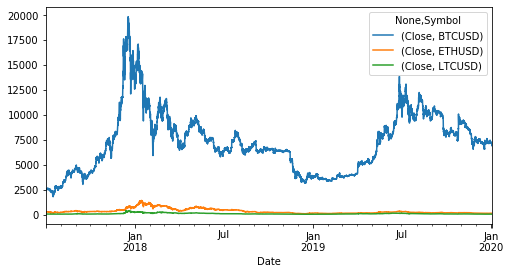

In [9]:
df = pd.concat(data.values(), sort=False).pivot(index='Date', columns='Symbol')
df[['Close']].plot(figsize=(8, 4))
plt.show()

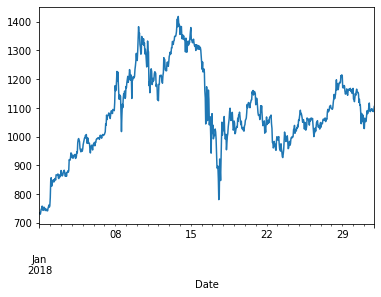

In [38]:
closed = df['Close'][COIN+'USD']

def slice(start=None, end=None):
  start = pd.to_datetime(start)
  end = pd.to_datetime(end)
  def _slice(df):
    return df[(df.index >= start) & (df.index < end)]
  return _slice

start_date = '2018-01-01' #@param {type:"date"}
end_date = '2018-02-01' #@param {type:"date"}

sample = slice(start_date, end_date)(closed)
sample.plot()
plt.show()

In [39]:
forecast_samples=24 # @param { type: 'number' }
obs = sample[:-forecast_samples]
obs

Date
2018-01-01 00:00:00     734.59
2018-01-01 01:00:00     730.02
2018-01-01 02:00:00     730.01
2018-01-01 03:00:00     739.70
2018-01-01 04:00:00     747.90
                        ...   
2018-01-30 19:00:00    1080.67
2018-01-30 20:00:00    1052.00
2018-01-30 21:00:00    1055.02
2018-01-30 22:00:00    1074.86
2018-01-30 23:00:00    1054.39
Name: ETHUSD, Length: 720, dtype: float64

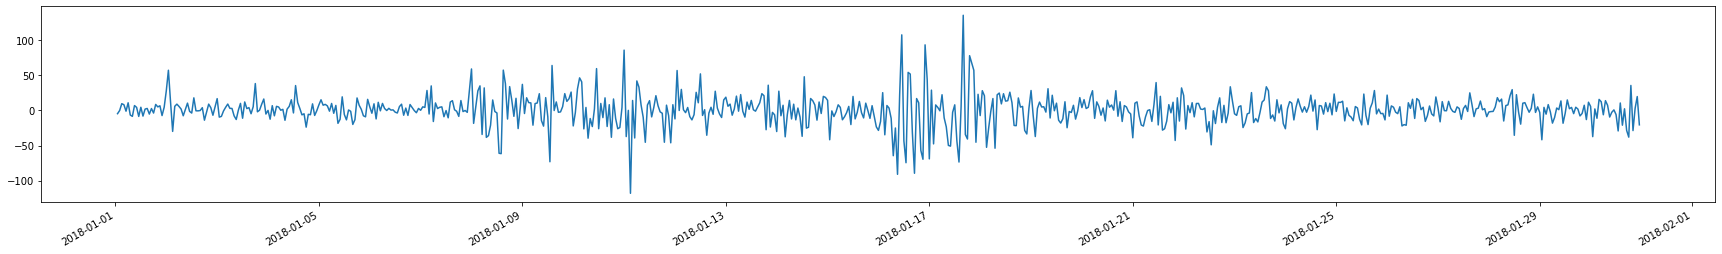

In [40]:
fig = plt.figure(figsize=(30,4))

plt.plot(sample.index[:-forecast_samples] ,obs.diff())
fig.autofmt_xdate()

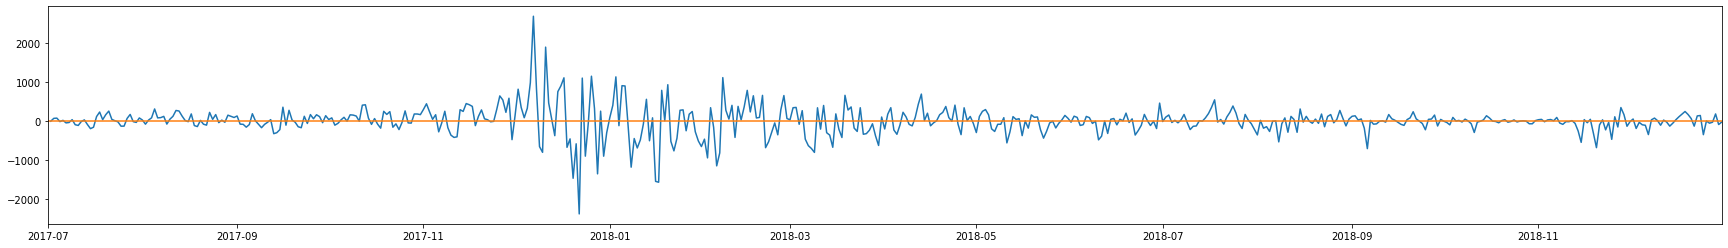

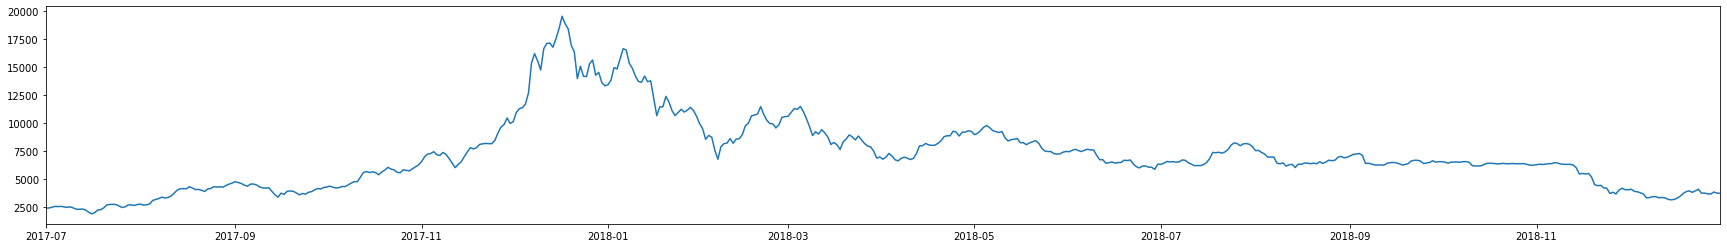

In [54]:
d = slice('2017', '2019')(df.groupby(df.index.date).mean().log().diff()['Open']['BTCUSD'])
ax = d.plot(figsize=(30,4))
ax.plot(d.index, np.zeros(len(d)))
plt.show()
d = slice('2017', '2019')(df.groupby(df.index.date).mean()['Open']['BTCUSD'])
ax = d.plot(figsize=(30,4))
plt.show()

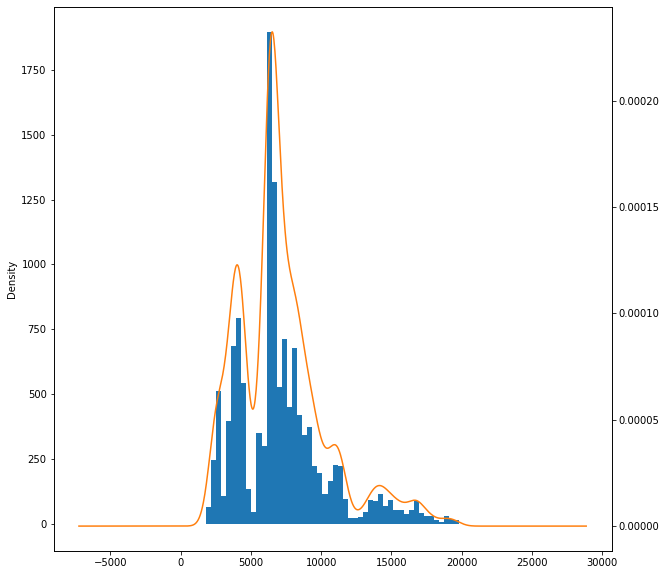

In [113]:
ax = slice('2017', '2019')(df)['Close']['BTCUSD'].hist(figsize=(10,10), bins=50)
slice('2017', '2019')(df)['Close']['BTCUSD'].plot.kde(secondary_y=True)
align.yaxes(ax, 0, ax,0, 0.05)


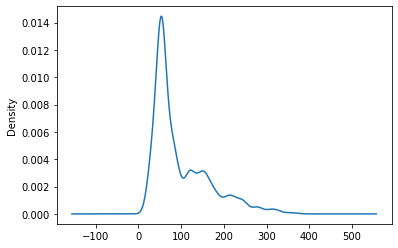

In [117]:
slice('2017', '2019')(df)['Close']['LTCUSD'].plot.kde()

In [8]:
hour_of_day_effect = tfp.sts.Seasonal(
    num_seasons=24,
    observed_time_series=obs,
    name='hour_of_day_effect')
day_of_week_effect = tfp.sts.Seasonal(
    num_seasons=7,
    num_steps_per_season=24, 
    observed_time_series=obs,
    name='day_of_week_effect')
residual_level = tfp.sts.Autoregressive(
    order=1,
    observed_time_series=obs, name='residual')
model = tfp.sts.Sum([ # hour_of_day_effect,
                      # day_of_week_effect,
                      residual_level],
                      observed_time_series=obs)

Instructions for updating:
Do not call `graph_parents`.


In [9]:
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=model)
num_variational_steps =  100 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

optimizer = tf.optimizers.Adam(learning_rate=.1)
# Using fit_surrogate_posterior to build and optimize the variational loss function.
@tf.function(experimental_compile=True)
def train():
  elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=model.joint_log_prob(
        observed_time_series=obs),
    surrogate_posterior=variational_posteriors,
    optimizer=optimizer,
    num_steps=num_variational_steps)
  return elbo_loss_curve

%time elbo_loss_curve = train()



Instructions for updating:
SeedStream has moved to `tfp.util.SeedStream`.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
CPU times: user 26.4 s, sys: 426 ms, total: 26.8 s
Wall time: 27.3 s


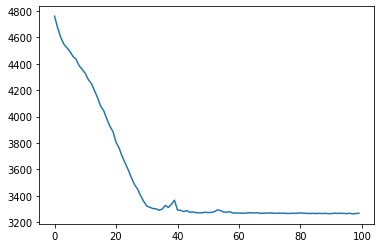

In [10]:
plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
q_samples= variational_posteriors.sample(forecast_samples)

In [11]:
print("Inferred parameters:")
for param in model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples[param.name], axis=0),
                              np.std(q_samples[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 6.4002140282979925 +- 0.5279988730293392
residual/_coefficients: [0.98821439] +- [0.00493919]
residual/_level_scale: 20.216375341203747 +- 0.5346290330309278


In [12]:
%%time 
forecast_dist = tfp.sts.forecast(
        model,
        observed_time_series=obs,
        parameter_samples=q_samples,
        num_steps_forecast=forecast_samples)

CPU times: user 11.3 s, sys: 330 ms, total: 11.6 s
Wall time: 10.8 s


In [13]:
forecast_dist.stddev()

<tf.Tensor: shape=(24, 1), dtype=float64, numpy=
array([[22.06999315],
       [29.76118921],
       [35.70918207],
       [40.68889588],
       [45.02546192],
       [48.8927234 ],
       [52.39687474],
       [55.60859   ],
       [58.57781979],
       [61.341481  ],
       [63.92781684],
       [66.35903782],
       [68.65300706],
       [70.82436202],
       [72.88528752],
       [74.84606438],
       [76.71546867],
       [78.50106861],
       [80.20944947],
       [81.84638693],
       [83.41698263],
       [84.92577154],
       [86.3768081 ],
       [87.77373594]])>

(24,) (24,)


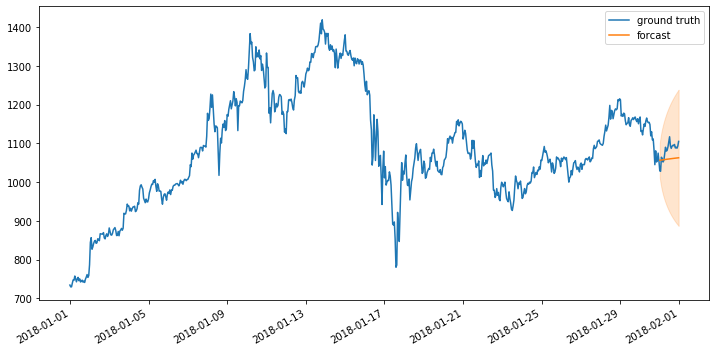

In [14]:
import seaborn as sns
colors = sns.color_palette()
c1, c2 = colors[:2]
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)

forecast_steps = sample.index[-forecast_samples:]
forecast_mean = forecast_dist.mean().numpy().reshape(-1)
forecast_scale = forecast_dist.stddev().numpy().reshape(-1)
print(forecast_mean.shape, forecast_scale.shape)
ax.plot(sample.index, sample, label='ground truth', color=c1)
ax.plot(forecast_steps, forecast_mean, label='forcast', color=c2)
ax.fill_between(forecast_steps,
                   (forecast_mean-2*forecast_scale),
                   (forecast_mean+2*forecast_scale), color=c2, alpha=0.2)
ax.legend()
fig.autofmt_xdate()
plt.show()

In [15]:
%%time
component_dists = tfp.sts.decompose_by_component(
    model,
    observed_time_series=sample,
    parameter_samples=q_samples)

CPU times: user 14.7 s, sys: 486 ms, total: 15.2 s
Wall time: 14.1 s


In [16]:
[k.name for k in component_dists.keys()]

['residual/']

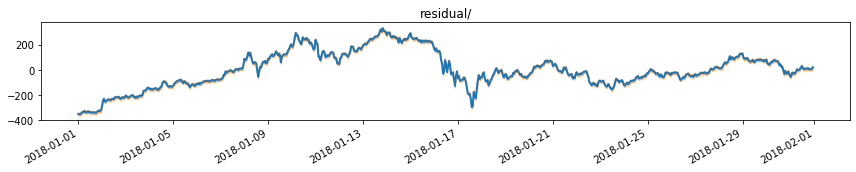

In [17]:
num_components = len(component_dists)
fig = plt.figure(figsize=(12, 2.5 * num_components))
for i, (component, dist) in enumerate(component_dists.items()):
  component_mean = dist.mean().numpy().reshape(-1)
  component_stddev = dist.stddev().numpy().reshape(-1)

  ax = fig.add_subplot(num_components,1,1+i)
  ax.plot(sample.index, component_mean, lw=2)
  ax.fill_between(sample.index,
                    component_mean-2*component_stddev,
                    component_mean+2*component_stddev,
                    color=c2, alpha=0.5)
  ax.set_title(component.name)
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

$z \sim N(0, 1)$

$x \sim N(z, 1)$

$P(z) = N(0, 1)$

$P(x|z) = N(z, 1)$

$P(x) = \int_z{P(x|z)P(z)dz}$

$D_{KL}[Q||P] = E_{z \sim Q}[log {Q(z) \over P(z|X)}] = \int_{z \sim Q} q(z)\log{q(z) \over p(z;X)}dz$ 

where $p$ and $q$ denote the probability densities of $P$ and $Q$


In [18]:
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

def log_prob(z, x):
  return tfd.Normal(0., 1.).log_prob(z) + tfd.Normal(z, 1.).log_prob(x)
conditioned_log_prob = lambda z: log_prob(z, x=5.)
q_z = tfd.Normal(loc=tf.Variable(0., name='q_z_loc'),
                 scale=tfp.util.DeferredTensor(
                   tf.nn.softplus,
                   tf.Variable(0., name='q_z_scale')), name='q_z')
losses = tfp.vi.fit_surrogate_posterior(
    conditioned_log_prob,
    surrogate_posterior=q_z,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=1000)
print(q_z.mean(), q_z.stddev())  # => approximately [2.5, 1/sqrt(2)]
print([2.5, 1/np.sqrt(2)])

tf.Tensor(2.368087, shape=(), dtype=float32) tf.Tensor(0.85561275, shape=(), dtype=float32)
[2.5, 0.7071067811865475]
